# Task 2

### Data Preprocessing
* Resize input images to 64×64×3 or 128×128×3, depending on available computational resources
* Normalize both training and testing image sets

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from sklearn.model_selection import train_test_split

IMAGE_SIZE = 128
NUM_CHANNELS = 3
NUM_CLASSES = 20
BATCH_SIZE = 32
TEST_SPLIT = 0.2
VALIDATION_SPLIT = 0.1
SEED = 42

DATA_DIR = "coil-20-proc/coil-20-proc"


def parse_class_label_from_filename(filename):
    object_prefix = filename.split("__")[0]
    one_indexed_label = int(object_prefix.replace("obj", ""))
    return one_indexed_label - 1


def load_coil20_images_and_labels(data_dir):
    all_images = []
    all_labels = []
    for filename in sorted(os.listdir(data_dir)):
        if not filename.endswith(".png"):
            continue
        label = parse_class_label_from_filename(filename)
        grayscale_image = Image.open(os.path.join(data_dir, filename))
        rgb_image = grayscale_image.convert("RGB").resize((IMAGE_SIZE, IMAGE_SIZE))
        all_images.append(np.array(rgb_image))
        all_labels.append(label)
    return np.array(all_images), np.array(all_labels)


def normalize_pixel_values(images):
    return images.astype(np.float32) / 255.0


def numpy_to_channels_first_tensor(images):
    return torch.tensor(images).permute(0, 3, 1, 2)


class COIL20Dataset(Dataset):
    def __init__(self, image_tensors, label_tensors):
        self.image_tensors = image_tensors
        self.label_tensors = label_tensors

    def __len__(self):
        return len(self.label_tensors)

    def __getitem__(self, idx):
        return self.image_tensors[idx], self.label_tensors[idx]


raw_images, labels = load_coil20_images_and_labels(DATA_DIR)
print(f"Loaded {raw_images.shape[0]} images of shape {raw_images.shape[1:]}")
print(f"Classes: {np.unique(labels)}")
print(f"Pixel range before normalization: [{raw_images.min()}, {raw_images.max()}]")

normalized_images = normalize_pixel_values(raw_images)
print(f"Pixel range after normalization: [{normalized_images.min():.2f}, {normalized_images.max():.2f}]")

train_images, test_images, train_labels, test_labels = train_test_split(
    normalized_images, labels, test_size=TEST_SPLIT, random_state=SEED, stratify=labels
)
print(f"\nTraining set: {train_images.shape[0]} samples")
print(f"Testing set:  {test_images.shape[0]} samples")

train_image_tensors = numpy_to_channels_first_tensor(train_images)
test_image_tensors = numpy_to_channels_first_tensor(test_images)
train_label_tensors = torch.tensor(train_labels, dtype=torch.long)
test_label_tensors = torch.tensor(test_labels, dtype=torch.long)

train_dataset = COIL20Dataset(train_image_tensors, train_label_tensors)
test_dataset = COIL20Dataset(test_image_tensors, test_label_tensors)

train_subset_size = int((1 - VALIDATION_SPLIT) * len(train_dataset))
val_subset_size = len(train_dataset) - train_subset_size
train_subset, val_subset = random_split(
    train_dataset, [train_subset_size, val_subset_size],
    generator=torch.Generator().manual_seed(SEED)
)

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nTrain loader: {len(train_subset)} samples, {len(train_loader)} batches")
print(f"Val loader:   {len(val_subset)} samples, {len(val_loader)} batches")
print(f"Test loader:  {len(test_dataset)} samples, {len(test_loader)} batches")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

Loaded 1440 images of shape (128, 128, 3)
Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Pixel range before normalization: [0, 255]
Pixel range after normalization: [0.00, 1.00]

Training set: 1152 samples
Testing set:  288 samples

Train loader: 1036 samples, 33 batches
Val loader:   116 samples, 4 batches
Test loader:  288 samples, 9 batches

Using device: cpu


### Activation Function Design and Comparison
* Use an AI-assistive system to design a novel activation function (reference: ReLU, Swish, GELU, TeLU, etc.)
* Integrate the proposed activation function into the DCNN
* Compare its performance against standard activation functions such as ReLU and GELU

**Prompt:** Let's design an activation function. Remember, we can reference RELU, Swish, GELU, TELU, etc. We want to try something a little novel but I prefer one that's simple. I like the idea of rational functions.

**Response:** Nice idea. Here's a clean one — basically Swish, but replacing the exponential sigmoid with the algebraic softsign:

**Swish** = `x · σ(x)` where `σ(x) = 1/(1+e^(-x))`

**RSwish** (Rational Swish) = `x · (1 + x/(1+|x|)) / 2`

The term `(1 + x/(1+|x|)) / 2` is a rational approximation of the sigmoid — it maps to (0, 1) just like sigmoid but with no exponentials.

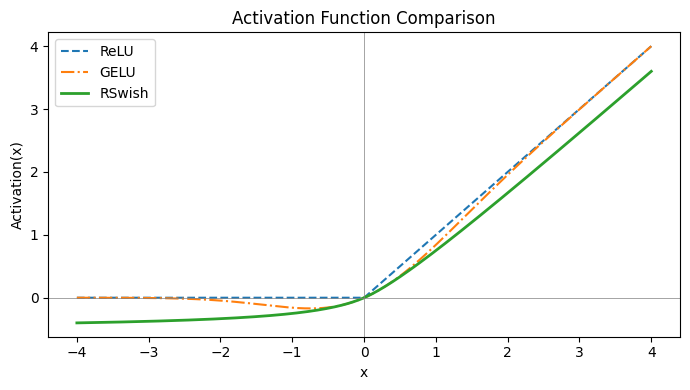

RSwish at key points:
  RSwish(-2.0) = -0.3333
  RSwish(-1.0) = -0.2500
  RSwish(+0.0) = 0.0000
  RSwish(+1.0) = 0.7500
  RSwish(+2.0) = 1.6667


In [24]:
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


class RSwish(nn.Module):
    """Rational Swish activation function.

    Replaces the exponential sigmoid in Swish with an algebraic softsign
    approximation, avoiding transcendental operations entirely:

        RSwish(x) = x * (1 + x / (1 + |x|)) / 2

    The factor (1 + x/(1+|x|)) / 2 is a rational approximation of sigmoid
    that maps (-inf, +inf) -> (0, 1), matching sigmoid's range without any
    exponentials.
    """

    def forward(self, x):
        rational_sigmoid = (1 + x / (1 + x.abs())) / 2
        return x * rational_sigmoid


def get_activation(name: str) -> nn.Module:
    """Return an activation module by name.

    Supported names: 'relu', 'gelu', 'rswish'.
    """
    name = name.lower()
    if name == "relu":
        return nn.ReLU()
    elif name == "gelu":
        return nn.GELU()
    elif name == "rswish":
        return RSwish()
    else:
        raise ValueError(f"Unknown activation '{name}'. Choose from: relu, gelu, rswish.")


# --- Visualize and compare the three activation functions ---
x = torch.linspace(-4, 4, 500)

with torch.no_grad():
    y_relu   = get_activation("relu")(x)
    y_gelu   = get_activation("gelu")(x)
    y_rswish = get_activation("rswish")(x)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(x, y_relu,   label="ReLU",   linestyle="--")
ax.plot(x, y_gelu,   label="GELU",   linestyle="-.")
ax.plot(x, y_rswish, label="RSwish", linestyle="-", linewidth=2)
ax.axhline(0, color="gray", linewidth=0.5)
ax.axvline(0, color="gray", linewidth=0.5)
ax.set_xlabel("x")
ax.set_ylabel("Activation(x)")
ax.set_title("Activation Function Comparison")
ax.legend()
plt.tight_layout()
plt.savefig("figures/task2_activation_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

print("RSwish at key points:")
for val in [-2.0, -1.0, 0.0, 1.0, 2.0]:
    t = torch.tensor(val)
    print(f"  RSwish({val:+.1f}) = {RSwish()(t).item():.4f}")

In [9]:
class DCNN(nn.Module):
    """Deep Convolutional Neural Network for COIL-20 classification.

    Architecture (for 128x128x3 input):
        Conv1: 8  filters (3x3) -> Activation -> MaxPool (2x2)  => 64x64x8
        Conv2: 16 filters (3x3) -> Activation -> MaxPool (2x2)  => 32x32x16
        Conv3: 32 filters (3x3) -> Activation -> MaxPool (2x2)  => 16x16x32
        Conv4: 64 filters (3x3) -> Activation                   => 16x16x64
        Flatten                                                   => 16384
        FC1:  16384 -> 512 -> Activation
        FC2:    512 -> 200 -> Activation
        FC3:    200 -> 100 -> Activation
        Output: 100 -> 20  (logits; use CrossEntropyLoss which applies softmax internally)

    Args:
        activation: one of 'relu', 'gelu', 'rswish'  (default: 'relu')
        num_classes: number of output classes          (default: 20)
        image_size:  spatial side length of input      (default: 128)
        in_channels: number of input channels          (default: 3)
    """

    def __init__(
        self,
        activation: str = "relu",
        num_classes: int = NUM_CLASSES,
        image_size: int = IMAGE_SIZE,
        in_channels: int = NUM_CHANNELS,
    ):
        super().__init__()
        self.activation_name = activation

        def act():
            return get_activation(activation)

        # --- Convolutional block ---
        # padding=1 keeps spatial dims the same; MaxPool(2,2) halves them.
        # After 4 pools on a 128-side input: 128 -> 64 -> 32 -> 16 -> 16
        # (Conv4 has no pool, so spatial size stays at 16 after Conv4.)
        self.conv_block = nn.Sequential(
            # Conv1
            nn.Conv2d(in_channels, 8, kernel_size=3, padding=1),
            act(),
            nn.MaxPool2d(2, 2),
            # Conv2
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            act(),
            nn.MaxPool2d(2, 2),
            # Conv3
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            act(),
            nn.MaxPool2d(2, 2),
            # Conv4
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            act(),
        )

        # Compute flatten size dynamically so the model stays correct if
        # IMAGE_SIZE is ever changed.
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, image_size, image_size)
            flatten_size = self.conv_block(dummy).numel()

        # --- Fully connected block ---
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flatten_size, 512),
            act(),
            nn.Linear(512, 200),
            act(),
            nn.Linear(200, 100),
            act(),
            nn.Linear(100, num_classes),
        )

    def forward(self, x):
        x = self.conv_block(x)
        return self.fc_block(x)


# --- Sanity check ---
for act_name in ("relu", "gelu", "rswish"):
    model = DCNN(activation=act_name).to(device)
    dummy_input = torch.zeros(2, NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE).to(device)
    out = model(dummy_input)
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"[{act_name.upper():6s}] output shape: {tuple(out.shape)}  |  trainable params: {total_params:,}")

print("\nDCNN ready. Use DCNN(activation='relu'|'gelu'|'rswish') to instantiate.")

[RELU  ] output shape: (2, 20)  |  trainable params: 8,538,368
[GELU  ] output shape: (2, 20)  |  trainable params: 8,538,368
[RSWISH] output shape: (2, 20)  |  trainable params: 8,538,368

DCNN ready. Use DCNN(activation='relu'|'gelu'|'rswish') to instantiate.


### Model Optimization
Train the model using the following optimization methods:
* Stochastic Gradient Descent (SGD) with momentum
* Adam optimizer

### Training Analysis
Plot training and validation loss curves to demonstrate learning behavior and convergence during training

In [4]:
import torch.optim as optim

NUM_EPOCHS    = 15
LEARNING_RATE = 1e-3
SGD_MOMENTUM  = 0.9
WEIGHT_DECAY  = 1e-4

ACTIVATION_NAMES = ["relu", "gelu", "rswish"]
OPTIMIZER_NAMES  = ["sgd", "adam"]


def make_optimizer(name, params, lr=LEARNING_RATE):
    if name == "sgd":
        return optim.SGD(params, lr=lr, momentum=SGD_MOMENTUM, weight_decay=WEIGHT_DECAY)
    elif name == "adam":
        return optim.Adam(params, lr=lr, weight_decay=WEIGHT_DECAY)
    raise ValueError(f"Unknown optimizer '{name}'")


def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
        correct    += outputs.argmax(1).eq(labels).sum().item()
        total      += images.size(0)
    return total_loss / total, correct / total


def evaluate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            correct    += outputs.argmax(1).eq(labels).sum().item()
            total      += images.size(0)
    return total_loss / total, correct / total


In [5]:
import os

MODELS_DIR = "saved_models"
os.makedirs(MODELS_DIR, exist_ok=True)


def _model_ckpt_path(act_name, opt_name):
    return os.path.join(MODELS_DIR, f"dcnn_{act_name}_{opt_name}.pt")


def _history_ckpt_path(act_name, opt_name):
    return os.path.join(MODELS_DIR, f"history_{act_name}_{opt_name}.pt")


criterion = nn.CrossEntropyLoss()
history   = {}

for act_name in ACTIVATION_NAMES:
    for opt_name in OPTIMIZER_NAMES:
        key    = (act_name, opt_name)
        m_path = _model_ckpt_path(act_name, opt_name)
        h_path = _history_ckpt_path(act_name, opt_name)

        model = DCNN(activation=act_name).to(device)

        if os.path.exists(m_path) and os.path.exists(h_path):
            model.load_state_dict(torch.load(m_path, map_location=device))
            model.eval()
            rec = torch.load(h_path, weights_only=False)
            rec["model"] = model
            print(f"[LOADED]  {act_name.upper()} + {opt_name.upper()}  <-  {m_path}")
        else:
            print(f"\n{'='*60}")
            print(f"  Activation: {act_name.upper():6s}  |  Optimizer: {opt_name.upper()}")
            print('='*60)

            optimizer = make_optimizer(opt_name, model.parameters())
            rec = {"train_losses": [], "val_losses": [],
                   "train_accs":   [], "val_accs":   []}

            for epoch in range(1, NUM_EPOCHS + 1):
                t_loss, t_acc = train_epoch(model, train_loader, optimizer, criterion, device)
                v_loss, v_acc = evaluate_epoch(model, val_loader, criterion, device)

                rec["train_losses"].append(t_loss)
                rec["val_losses"].append(v_loss)
                rec["train_accs"].append(t_acc)
                rec["val_accs"].append(v_acc)

                if epoch == 1 or epoch % 5 == 0:
                    print(f"  Epoch {epoch:3d}/{NUM_EPOCHS} | "
                          f"Train  loss={t_loss:.4f} acc={t_acc:.3f} | "
                          f"Val    loss={v_loss:.4f} acc={v_acc:.3f}")

            # Save model weights and training history separately
            torch.save(model.state_dict(), m_path)
            torch.save({k: v for k, v in rec.items()}, h_path)
            print(f"  Saved -> {m_path}")
            rec["model"] = model

        history[key] = rec

print("\nAll combinations ready.")



  Activation: RELU    |  Optimizer: SGD
  Epoch   1/15 | Train  loss=2.9987 acc=0.047 | Val    loss=2.9920 acc=0.078
  Epoch   5/15 | Train  loss=2.9980 acc=0.047 | Val    loss=2.9927 acc=0.078
  Epoch  10/15 | Train  loss=2.9973 acc=0.047 | Val    loss=2.9939 acc=0.078
  Epoch  15/15 | Train  loss=2.9966 acc=0.066 | Val    loss=2.9947 acc=0.034
  Saved -> saved_models\dcnn_relu_sgd.pt

  Activation: RELU    |  Optimizer: ADAM
  Epoch   1/15 | Train  loss=2.9438 acc=0.085 | Val    loss=2.2214 acc=0.319
  Epoch   5/15 | Train  loss=0.1134 acc=0.964 | Val    loss=0.0346 acc=1.000
  Epoch  10/15 | Train  loss=0.0003 acc=1.000 | Val    loss=0.0002 acc=1.000
  Epoch  15/15 | Train  loss=0.0001 acc=1.000 | Val    loss=0.0001 acc=1.000
  Saved -> saved_models\dcnn_relu_adam.pt

  Activation: GELU    |  Optimizer: SGD
  Epoch   1/15 | Train  loss=2.9971 acc=0.047 | Val    loss=3.0033 acc=0.069
  Epoch   5/15 | Train  loss=2.9968 acc=0.047 | Val    loss=3.0033 acc=0.069
  Epoch  10/15 | Train 

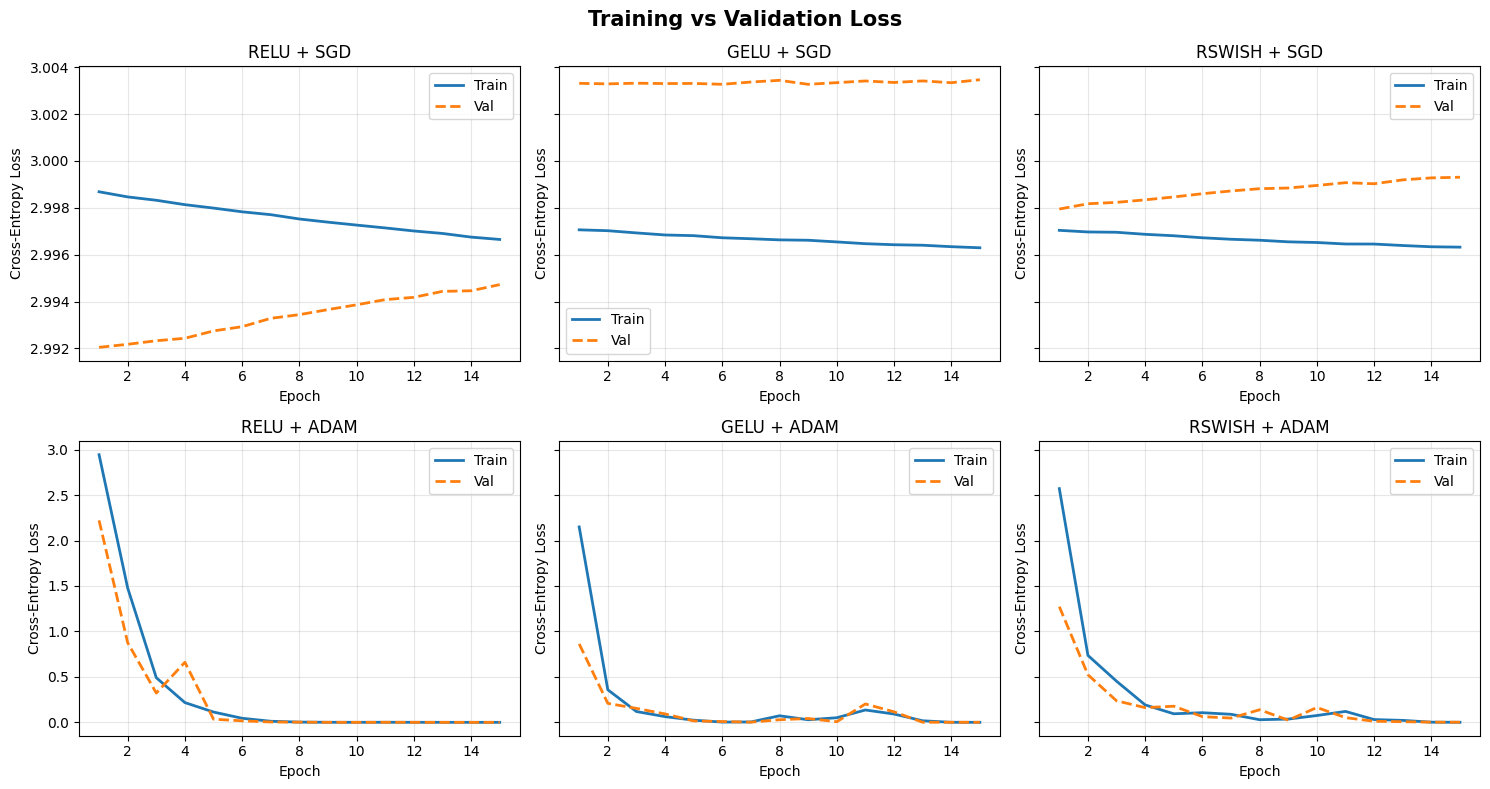

In [15]:
epochs = range(1, NUM_EPOCHS + 1)

fig, axes = plt.subplots(len(OPTIMIZER_NAMES), len(ACTIVATION_NAMES),
                         figsize=(15, 8), sharey="row")
fig.suptitle("Training vs Validation Loss", fontsize=15, fontweight="bold")

for row, opt_name in enumerate(OPTIMIZER_NAMES):
    for col, act_name in enumerate(ACTIVATION_NAMES):
        ax  = axes[row][col]
        rec = history[(act_name, opt_name)]
        ax.plot(epochs, rec["train_losses"], label="Train", linewidth=2)
        ax.plot(epochs, rec["val_losses"],   label="Val",   linewidth=2, linestyle="--")
        ax.set_title(f"{act_name.upper()} + {opt_name.upper()}")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Cross-Entropy Loss")
        ax.legend()
        ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("figures/task2_training_loss_curves.png", dpi=150, bbox_inches="tight")
plt.show()


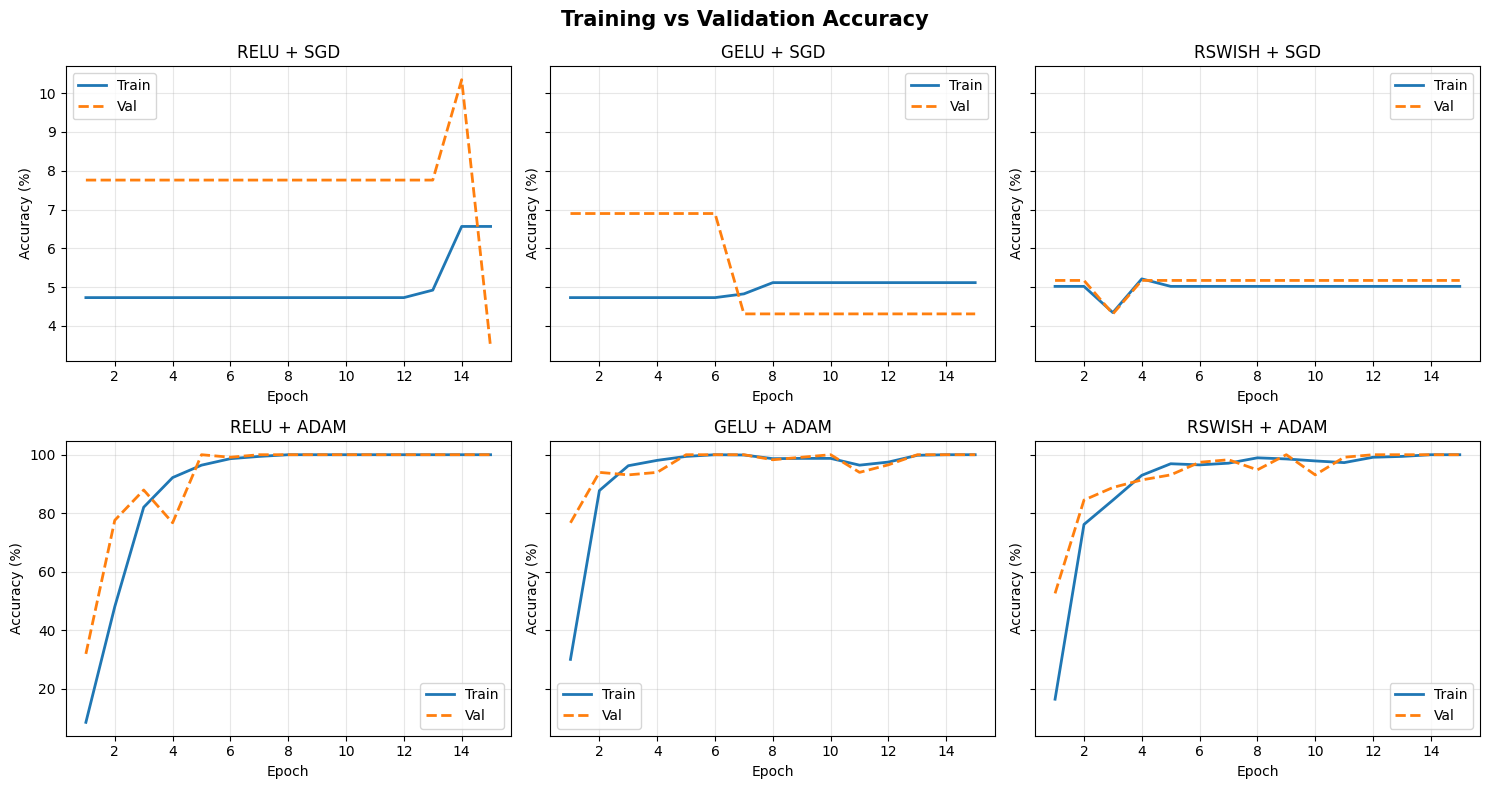

In [14]:
epochs = range(1, NUM_EPOCHS + 1)

fig, axes = plt.subplots(len(OPTIMIZER_NAMES), len(ACTIVATION_NAMES),
                         figsize=(15, 8), sharey="row")
fig.suptitle("Training vs Validation Accuracy", fontsize=15, fontweight="bold")

for row, opt_name in enumerate(OPTIMIZER_NAMES):
    for col, act_name in enumerate(ACTIVATION_NAMES):
        ax  = axes[row][col]
        rec = history[(act_name, opt_name)]
        ax.plot(epochs, [a * 100 for a in rec["train_accs"]], label="Train", linewidth=2)
        ax.plot(epochs, [a * 100 for a in rec["val_accs"]],   label="Val",   linewidth=2, linestyle="--")
        ax.set_title(f"{act_name.upper()} + {opt_name.upper()}")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Accuracy (%)")
        ax.legend()
        ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("figures/task2_training_accuracy_curves.png", dpi=150, bbox_inches="tight")
plt.show()


In [12]:
print(f"\n{'─'*72}")
print(f"{'Combination':<22} {'Train Loss':>10} {'Val Loss':>10} {'Train Acc':>10} {'Val Acc':>10}")
print(f"{'─'*72}")
for act_name in ACTIVATION_NAMES:
    for opt_name in OPTIMIZER_NAMES:
        rec   = history[(act_name, opt_name)]
        combo = f"{act_name.upper()}+{opt_name.upper()}"
        print(f"{combo:<22} "
              f"{rec['train_losses'][-1]:>10.4f} "
              f"{rec['val_losses'][-1]:>10.4f} "
              f"{rec['train_accs'][-1]*100:>9.2f}% "
              f"{rec['val_accs'][-1]*100:>9.2f}%")
print(f"{'─'*72}")



────────────────────────────────────────────────────────────────────────
Combination            Train Loss   Val Loss  Train Acc    Val Acc
────────────────────────────────────────────────────────────────────────
RELU+SGD                   2.9966     2.9947      6.56%      3.45%
RELU+ADAM                  0.0001     0.0001    100.00%    100.00%
GELU+SGD                   2.9963     3.0035      5.12%      4.31%
GELU+ADAM                  0.0003     0.0008    100.00%    100.00%
RSWISH+SGD                 2.9963     2.9993      5.02%      5.17%
RSWISH+ADAM                0.0007     0.0015    100.00%    100.00%
────────────────────────────────────────────────────────────────────────


### Model Evaluation
Evaluate the trained model on the test dataset using the following performance metrics:
* Accuracy
* Precision
* Recall
* F1-score
* Confusion matrix
* ROC curve
* Precision–Recall curve

Present overall performance without thresholding, then also report metrics for predictions with confidence > 0.9.

In [16]:
import torch.nn.functional as F
from sklearn.preprocessing import label_binarize

CLASSES = list(range(NUM_CLASSES))


def collect_test_predictions(model, loader, device):
    """Returns (y_true, y_pred, y_prob) numpy arrays over the full test loader."""
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            probs  = F.softmax(model(images), dim=1)
            all_labels.append(labels.cpu().numpy())
            all_preds.append(probs.argmax(dim=1).cpu().numpy())
            all_probs.append(probs.cpu().numpy())
    return (
        np.concatenate(all_labels),
        np.concatenate(all_preds),
        np.concatenate(all_probs),
    )


test_results = {}
for act_name in ACTIVATION_NAMES:
    for opt_name in OPTIMIZER_NAMES:
        key = (act_name, opt_name)
        y_true, y_pred, y_prob = collect_test_predictions(
            history[key]["model"], test_loader, device
        )
        test_results[key] = {"y_true": y_true, "y_pred": y_pred, "y_prob": y_prob}
        acc = (y_true == y_pred).mean()
        print(f"[{act_name.upper()} + {opt_name.upper()}]  "
              f"test acc = {acc*100:.2f}%  ({len(y_true)} samples)")


[RELU + SGD]  test acc = 4.86%  (288 samples)
[RELU + ADAM]  test acc = 99.65%  (288 samples)
[GELU + SGD]  test acc = 4.86%  (288 samples)
[GELU + ADAM]  test acc = 100.00%  (288 samples)
[RSWISH + SGD]  test acc = 4.86%  (288 samples)
[RSWISH + ADAM]  test acc = 100.00%  (288 samples)


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

header = (f"{'Combination':<22} {'Accuracy':>10} {'Precision':>10} "
          f"{'Recall':>10} {'F1-Score':>10}")
sep = "─" * len(header)
print(f"\nTest-set performance — macro-averaged over {NUM_CLASSES} classes (no threshold)\n")
print(sep)
print(header)
print(sep)

for act_name in ACTIVATION_NAMES:
    for opt_name in OPTIMIZER_NAMES:
        key  = (act_name, opt_name)
        r    = test_results[key]
        acc  = accuracy_score(r["y_true"], r["y_pred"])
        prec = precision_score(r["y_true"], r["y_pred"], average="macro", zero_division=0)
        rec  = recall_score(r["y_true"], r["y_pred"], average="macro", zero_division=0)
        f1   = f1_score(r["y_true"], r["y_pred"], average="macro", zero_division=0)
        combo = f"{act_name.upper()}+{opt_name.upper()}"
        print(f"{combo:<22} {acc*100:>9.2f}% {prec*100:>9.2f}% {rec*100:>9.2f}% {f1*100:>9.2f}%")

print(sep)



Test-set performance — macro-averaged over 20 classes (no threshold)

──────────────────────────────────────────────────────────────────
Combination              Accuracy  Precision     Recall   F1-Score
──────────────────────────────────────────────────────────────────
RELU+SGD                    4.86%      0.25%      5.00%      0.48%
RELU+ADAM                  99.65%     99.67%     99.64%     99.64%
GELU+SGD                    4.86%      0.24%      5.00%      0.46%
GELU+ADAM                 100.00%    100.00%    100.00%    100.00%
RSWISH+SGD                  4.86%      0.24%      5.00%      0.46%
RSWISH+ADAM               100.00%    100.00%    100.00%    100.00%
──────────────────────────────────────────────────────────────────


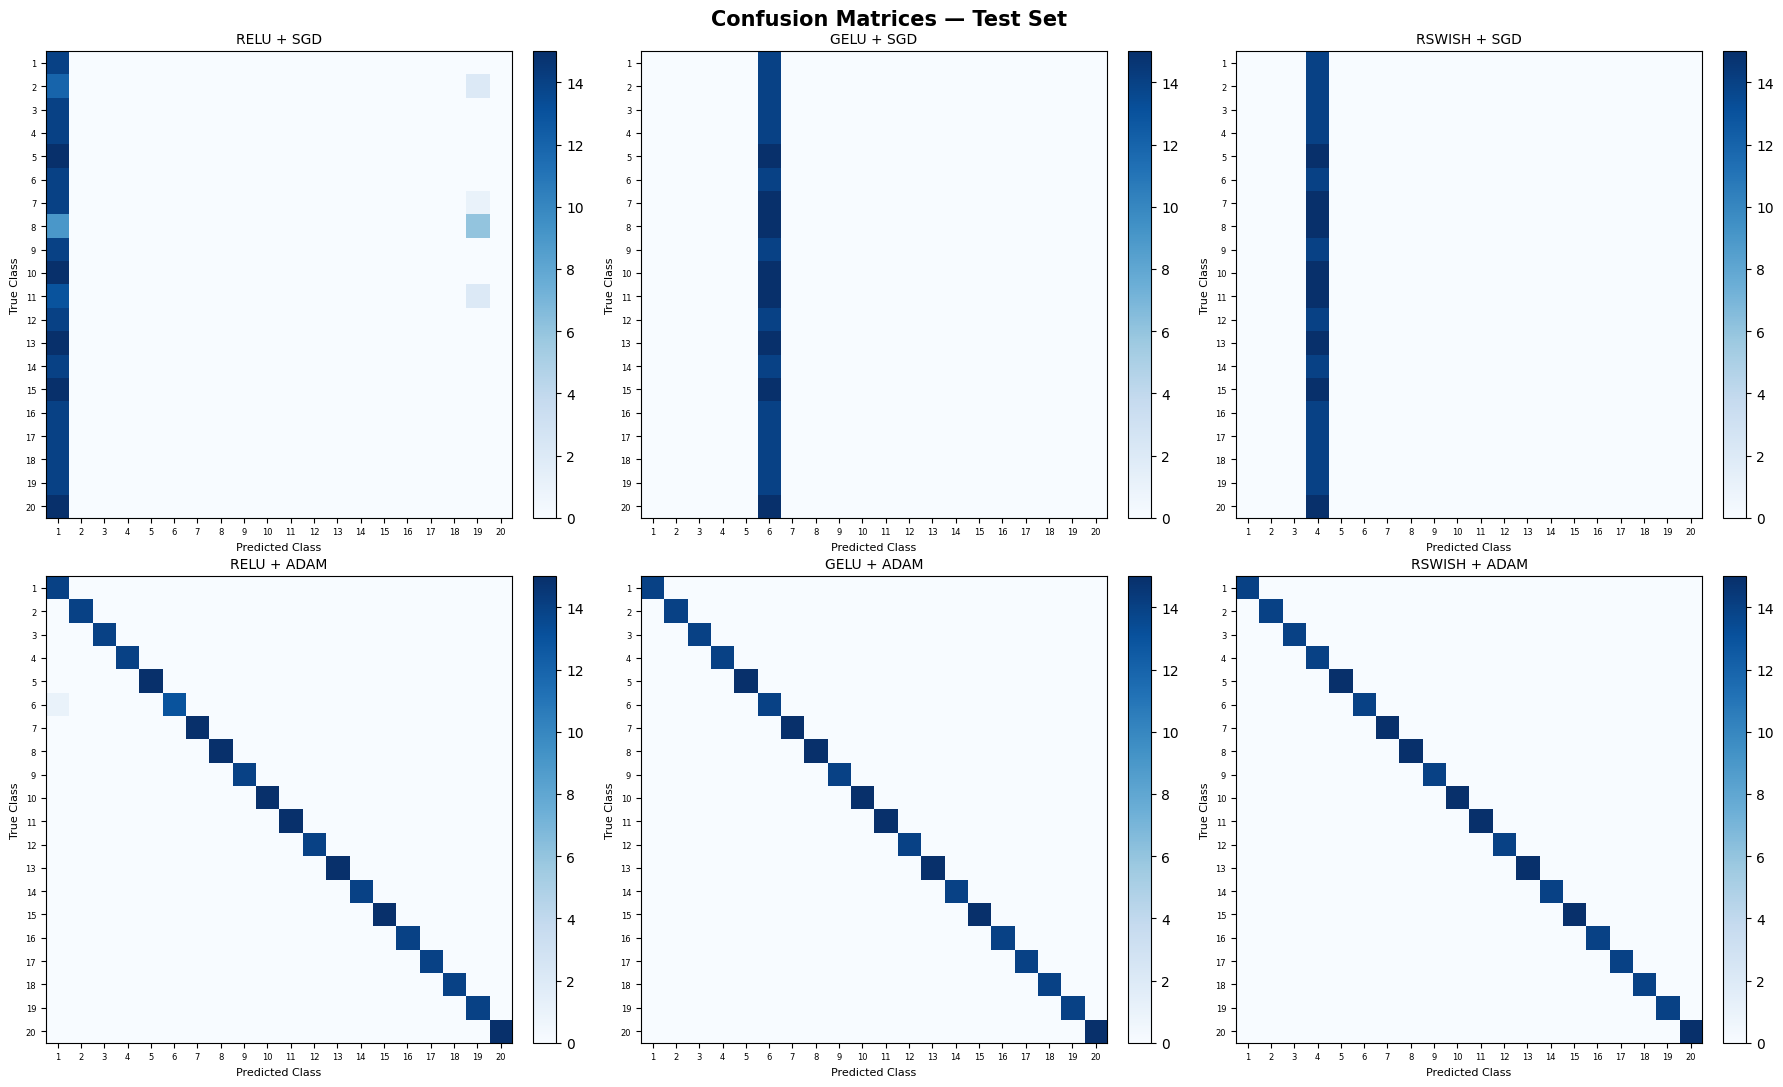

In [20]:
from sklearn.metrics import confusion_matrix

tick_labels = [str(i + 1) for i in range(NUM_CLASSES)]

fig, axes = plt.subplots(len(OPTIMIZER_NAMES), len(ACTIVATION_NAMES),
                         figsize=(18, 11))
fig.suptitle("Confusion Matrices — Test Set", fontsize=15, fontweight="bold")

for row, opt_name in enumerate(OPTIMIZER_NAMES):
    for col, act_name in enumerate(ACTIVATION_NAMES):
        ax  = axes[row][col]
        key = (act_name, opt_name)
        r   = test_results[key]
        cm  = confusion_matrix(r["y_true"], r["y_pred"], labels=list(range(NUM_CLASSES)))
        im  = ax.imshow(cm, interpolation="nearest", cmap="Blues")
        ax.set_title(f"{act_name.upper()} + {opt_name.upper()}", fontsize=10)
        ax.set_xticks(range(NUM_CLASSES))
        ax.set_yticks(range(NUM_CLASSES))
        ax.set_xticklabels(tick_labels, fontsize=6)
        ax.set_yticklabels(tick_labels, fontsize=6)
        ax.set_xlabel("Predicted Class", fontsize=8)
        ax.set_ylabel("True Class", fontsize=8)
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig("figures/task2_confusion_matrices.png", dpi=150, bbox_inches="tight")
plt.show()


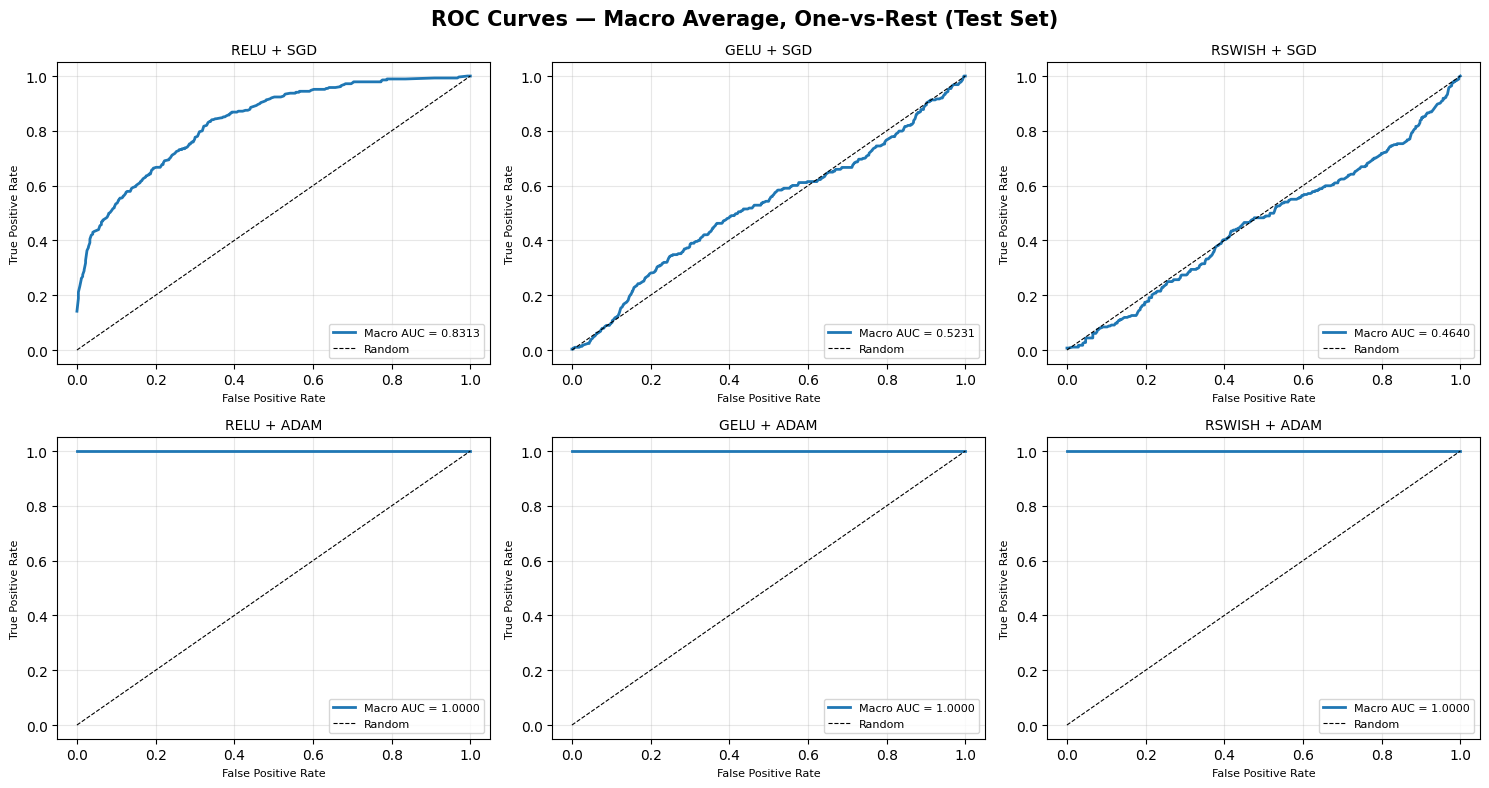

In [21]:
from sklearn.metrics import roc_curve, auc

fig, axes = plt.subplots(len(OPTIMIZER_NAMES), len(ACTIVATION_NAMES),
                         figsize=(15, 8))
fig.suptitle("ROC Curves — Macro Average, One-vs-Rest (Test Set)", fontsize=15, fontweight="bold")

for row, opt_name in enumerate(OPTIMIZER_NAMES):
    for col, act_name in enumerate(ACTIVATION_NAMES):
        ax  = axes[row][col]
        key = (act_name, opt_name)
        r   = test_results[key]
        y_bin = label_binarize(r["y_true"], classes=CLASSES)

        fpr_per_class, tpr_per_class = {}, {}
        for c in CLASSES:
            fpr_per_class[c], tpr_per_class[c], _ = roc_curve(y_bin[:, c], r["y_prob"][:, c])

        all_fpr  = np.unique(np.concatenate(list(fpr_per_class.values())))
        mean_tpr = np.mean(
            [np.interp(all_fpr, fpr_per_class[c], tpr_per_class[c]) for c in CLASSES],
            axis=0,
        )
        macro_auc = auc(all_fpr, mean_tpr)

        ax.plot(all_fpr, mean_tpr, linewidth=2, label=f"Macro AUC = {macro_auc:.4f}")
        ax.plot([0, 1], [0, 1], "k--", linewidth=0.8, label="Random")
        ax.set_title(f"{act_name.upper()} + {opt_name.upper()}", fontsize=10)
        ax.set_xlabel("False Positive Rate", fontsize=8)
        ax.set_ylabel("True Positive Rate", fontsize=8)
        ax.legend(loc="lower right", fontsize=8)
        ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("figures/task2_roc_curves.png", dpi=150, bbox_inches="tight")
plt.show()


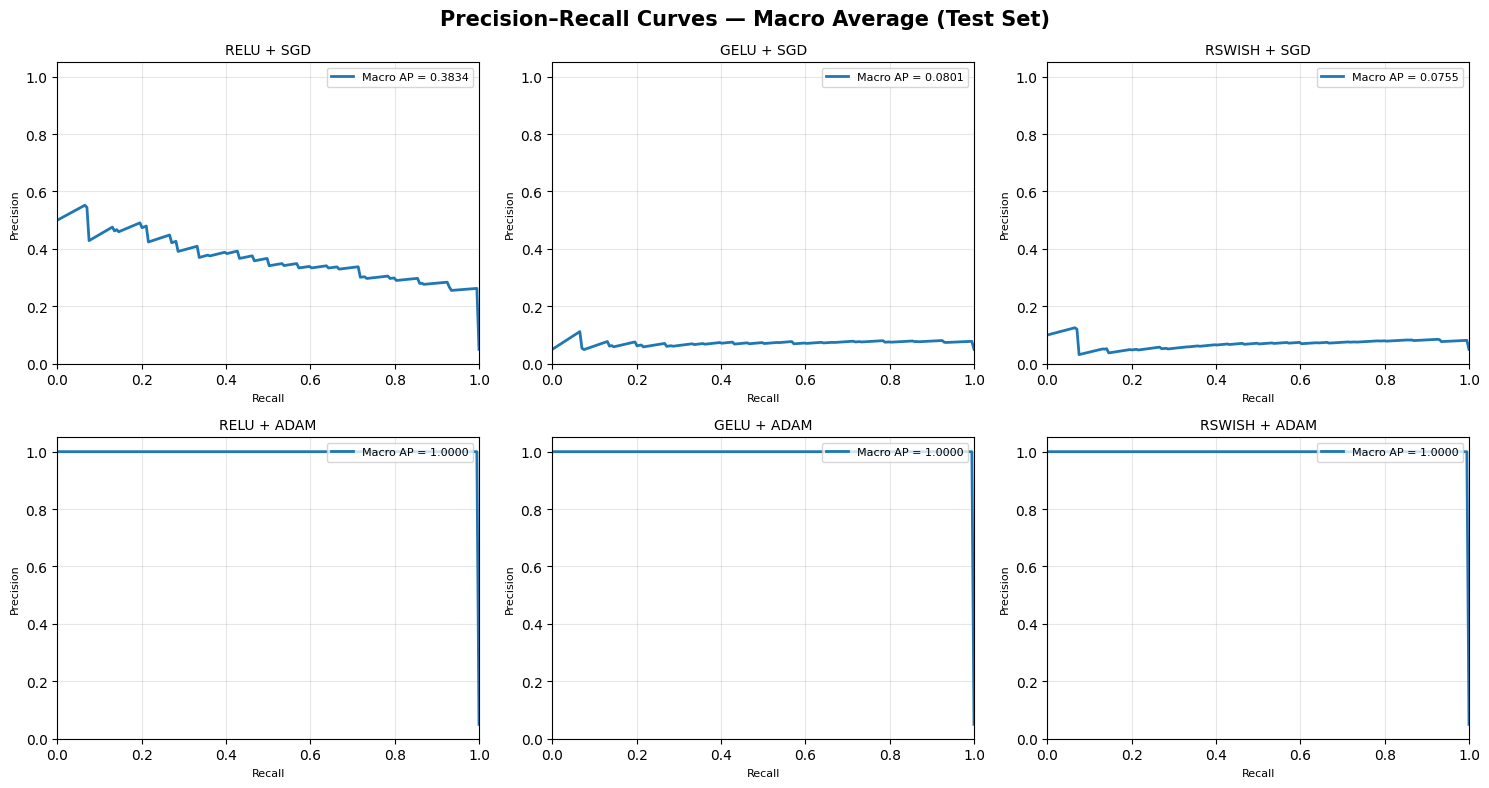

In [22]:
from sklearn.metrics import precision_recall_curve, average_precision_score

recall_grid = np.linspace(0, 1, 200)

fig, axes = plt.subplots(len(OPTIMIZER_NAMES), len(ACTIVATION_NAMES),
                         figsize=(15, 8))
fig.suptitle("Precision–Recall Curves — Macro Average (Test Set)", fontsize=15, fontweight="bold")

for row, opt_name in enumerate(OPTIMIZER_NAMES):
    for col, act_name in enumerate(ACTIVATION_NAMES):
        ax  = axes[row][col]
        key = (act_name, opt_name)
        r   = test_results[key]
        y_bin = label_binarize(r["y_true"], classes=CLASSES)

        ap_list, prec_interp_list = [], []
        for c in CLASSES:
            prec_c, rec_c, _ = precision_recall_curve(y_bin[:, c], r["y_prob"][:, c])
            ap_list.append(average_precision_score(y_bin[:, c], r["y_prob"][:, c]))
            # precision_recall_curve returns decreasing recall — reverse for interp
            prec_interp_list.append(np.interp(recall_grid, rec_c[::-1], prec_c[::-1]))

        mean_prec = np.mean(prec_interp_list, axis=0)
        macro_ap  = np.mean(ap_list)

        ax.plot(recall_grid, mean_prec, linewidth=2, label=f"Macro AP = {macro_ap:.4f}")
        ax.set_title(f"{act_name.upper()} + {opt_name.upper()}", fontsize=10)
        ax.set_xlabel("Recall", fontsize=8)
        ax.set_ylabel("Precision", fontsize=8)
        ax.legend(loc="upper right", fontsize=8)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1.05])
        ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("figures/task2_pr_curves.png", dpi=150, bbox_inches="tight")
plt.show()


In [23]:
CONFIDENCE_THRESHOLD = 0.9

print(f"Performance metrics at confidence threshold > {CONFIDENCE_THRESHOLD}")
print(f"(only predictions where max class probability > {CONFIDENCE_THRESHOLD} are evaluated)\n")

header = (f"{'Combination':<22} {'Retained':>10} {'Coverage':>10} "
          f"{'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1-Score':>10}")
sep = "─" * len(header)
print(sep)
print(header)
print(sep)

for act_name in ACTIVATION_NAMES:
    for opt_name in OPTIMIZER_NAMES:
        key  = (act_name, opt_name)
        r    = test_results[key]
        mask = r["y_prob"].max(axis=1) > CONFIDENCE_THRESHOLD
        n_ret    = int(mask.sum())
        coverage = n_ret / len(mask)
        combo    = f"{act_name.upper()}+{opt_name.upper()}"

        if n_ret == 0:
            print(f"{combo:<22} {n_ret:>10d} {coverage*100:>9.1f}%"
                  f" {'N/A':>10} {'N/A':>10} {'N/A':>10} {'N/A':>10}")
            continue

        y_t  = r["y_true"][mask]
        y_p  = r["y_pred"][mask]
        acc  = accuracy_score(y_t, y_p)
        prec = precision_score(y_t, y_p, average="macro", zero_division=0)
        rec  = recall_score(y_t, y_p, average="macro", zero_division=0)
        f1   = f1_score(y_t, y_p, average="macro", zero_division=0)

        print(f"{combo:<22} {n_ret:>10d} {coverage*100:>9.1f}%"
              f" {acc*100:>9.2f}% {prec*100:>9.2f}% {rec*100:>9.2f}% {f1*100:>9.2f}%")

print(sep)
print(f"\n* 'Retained' = samples where max class probability > {CONFIDENCE_THRESHOLD}")
print(f"* 'Coverage' = fraction of test set retained after thresholding")


Performance metrics at confidence threshold > 0.9
(only predictions where max class probability > 0.9 are evaluated)

────────────────────────────────────────────────────────────────────────────────────────
Combination              Retained   Coverage   Accuracy  Precision     Recall   F1-Score
────────────────────────────────────────────────────────────────────────────────────────
RELU+SGD                        0       0.0%        N/A        N/A        N/A        N/A
RELU+ADAM                     287      99.7%    100.00%    100.00%    100.00%    100.00%
GELU+SGD                        0       0.0%        N/A        N/A        N/A        N/A
GELU+ADAM                     288     100.0%    100.00%    100.00%    100.00%    100.00%
RSWISH+SGD                      0       0.0%        N/A        N/A        N/A        N/A
RSWISH+ADAM                   287      99.7%    100.00%    100.00%    100.00%    100.00%
─────────────────────────────────────────────────────────────────────────────────